# Reuters news classification by using LSTM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
from tensorflow.keras.datasets import reuters
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words = None, test_split = 0.2)

2113536/2110848 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


## Preprocessing

### Checking data

In [3]:
category = np.max(y_train) + 1
print(f"Number of category : {category}")
len(X_train), len(X_test)

Number of category : 46


(8982, 2246)

In [4]:
print(X_train[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [5]:
index_dict = {}
for key, value in reuters.get_word_index().items() :
    index_dict[value] = key
len(index_dict)

557056/550378 [==============================] - 0s 0us/step


30979

In [6]:
' '.join(index_dict[i] for i in X_train[0])

'the wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs'

In [7]:
print('Length of the longest news :', max(len(i) for i in X_train))
print('Average length of news :', sum(map(len, X_train)) / len(X_train))

Length of the longest news : 2376
Average length of news : 145.5398574927633


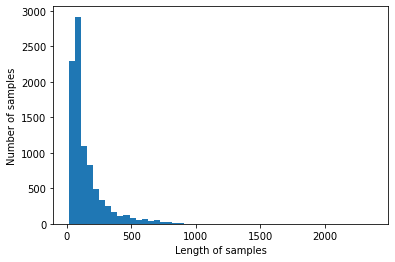

In [8]:
plt.hist([len(i) for i in X_train], bins = 50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


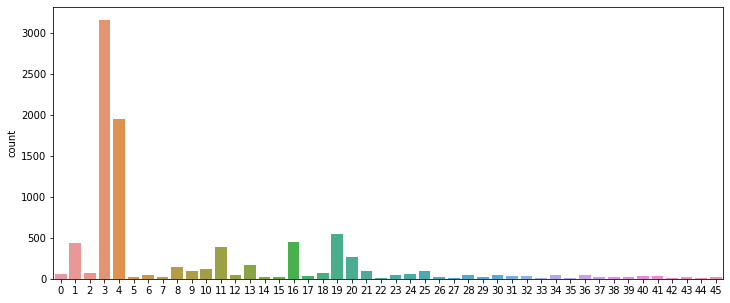

In [9]:
import seaborn as sns
plt.figure(figsize=(12,5))
sns.countplot(y_train)
plt.show()

In [10]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words = 1000, test_split = 0.2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 100
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

### Articles - one-hot encoding

In [12]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [13]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8982, 100), (2246, 100), (8982, 46), (2246, 46))

## Processing
- Words : frequency max 1000
- length of sentence : until 100 words

In [14]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [15]:
model = Sequential([
    Embedding(1000, 100),
    LSTM(120),
    Dense(category, activation = 'softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         100000    
_________________________________________________________________
lstm (LSTM)                  (None, 120)               106080    
_________________________________________________________________
dense (Dense)                (None, 46)                5566      
Total params: 211,646
Trainable params: 211,646
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Callback function

In [17]:
import os
if not os.path.exists('Models'):
    os.mkdir('Models')

model_file = 'Models/best_reuters_lstm.h5'
mc = ModelCheckpoint(model_file, save_best_only = True, verbose = 1)
es = EarlyStopping(patience = 10)

In [18]:
history = model.fit(X_train, Y_train, batch_size = 100, epochs = 50,
                    validation_split = 0.2, verbose = 2, callbacks = [mc, es])

Epoch 1/50
72/72 - 9s - loss: 2.6404 - accuracy: 0.3447 - val_loss: 2.4050 - val_accuracy: 0.3450

Epoch 00001: val_loss improved from inf to 2.40501, saving model to Models/best_reuters_lstm.h5
Epoch 2/50
72/72 - 1s - loss: 2.1605 - accuracy: 0.4500 - val_loss: 2.0818 - val_accuracy: 0.5003

Epoch 00002: val_loss improved from 2.40501 to 2.08177, saving model to Models/best_reuters_lstm.h5
Epoch 3/50
72/72 - 1s - loss: 1.9626 - accuracy: 0.5190 - val_loss: 1.8250 - val_accuracy: 0.5442

Epoch 00003: val_loss improved from 2.08177 to 1.82504, saving model to Models/best_reuters_lstm.h5
Epoch 4/50
72/72 - 1s - loss: 1.7473 - accuracy: 0.5635 - val_loss: 1.7586 - val_accuracy: 0.5576

Epoch 00004: val_loss improved from 1.82504 to 1.75859, saving model to Models/best_reuters_lstm.h5
Epoch 5/50
72/72 - 1s - loss: 1.6990 - accuracy: 0.5708 - val_loss: 1.6903 - val_accuracy: 0.5671

Epoch 00005: val_loss improved from 1.75859 to 1.69027, saving model to Models/best_reuters_lstm.h5
Epoch 6/5

In [19]:
best_model = load_model(model_file)
best_model.evaluate(X_test, Y_test)

71/71 [==============================] - 1s 5ms/step - loss: 1.2388 - accuracy: 0.7026


[1.2387899160385132, 0.7025823593139648]

## Visualization
- 1 x axis, 2 y axis scale

In [20]:
y_acc = history.history['accuracy']
y_vacc = history.history['val_accuracy']
y_loss = history.history['loss']
y_vloss = history.history['val_loss']
x_len = np.arange(1, len(y_acc) + 1)

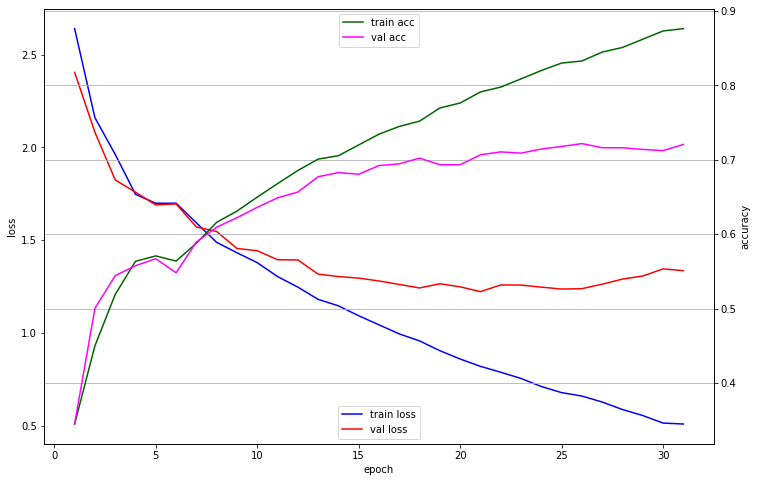

In [21]:
fig, ax0 = plt.subplots(figsize = (12, 8))
ax1 = ax0.twinx()

ax0.plot(x_len, y_loss, c = 'blue', label = 'train loss')
ax0.plot(x_len, y_vloss, c = 'red', label = 'val loss')
ax0.set_ylabel('loss')

ax1.plot(x_len, y_acc, c = 'darkgreen', label = 'train acc')
ax1.plot(x_len, y_vacc, c = 'magenta', label = 'val acc')
ax1.set_ylabel('accuracy')

ax0.set_xlabel('epoch')
ax0.legend(loc = 'lower center'); ax1.legend(loc = 'upper center')
plt.grid()
plt.show()